# Part 2: Imbalanced Classification on MedMNIST

In [5]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# todo
def train_epoch(model, device, train_loader, optimizer,criterion):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model.
        device (torch.device): The device to use (cuda or cpu).
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        criterion (nn.Module): The loss function.

    Returns:
        float: The average training loss for the epoch.
    """
    model.train() # Set the model to training mode
    running_loss = 0.0

    for batch, (X, y) in enumerate(train_loader):
      X, y = X.to(device), y.to(device)
      logits = model(X)
      loss = criterion(logits, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    running_loss /= len(train_loader) # average loss per batch
    # todo: Implement the training loop:
    # Perflogitsologitsass + backward pass, update model weights and running_loss
    # print("todo: Implement train_epoch")

    return running_loss

In [23]:
# todo
def plot_results(train_losses, val_losses, val_metrics, metric_name=""):
    """
    Plots the training and validation metrics.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        val_metrics (list): List of validation metrics per epoch.
    """
    # TODO: Implement plotting
    # Create two subplots:
    # 1. Loss (Training vs. Validation) vs. Epoch
    # 2. Metric (Validation) vs. Epoch
    # print("TODO: Implement plot_results")
    epochs = range(len(train_losses))
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.6)

    ax[0].plot(epochs, train_losses, label="train loss")
    ax[0].plot(epochs, val_losses, label="val loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Train Loss Val")
    ax[0].legend()

    ax[1].plot(epochs, val_metrics)
    ax[1].set_title(metric_name)
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel(metric_name)
    ax[1].set_title(f"val {metric_name}")

In [1]:
!pip install libauc
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.3 MB/s eta 0:00:00


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.sampler import DualSampler
import medmnist

from medmnist import ChestMNIST

In [3]:
from libauc.metrics import auc_roc_score

def auc_fn(pred, y): # pred: is y_score in auc sklearn
  y_pred = pred.detach().cpu().numpy()
  y = y.detach().cpu().numpy()
  auc = auc_roc_score(y_true=y, y_pred=y_pred)
  return auc

# todo
def validate_epoch(model, device, val_loader, criterion):
    """
    Validates the model for one epoch.

    Args:
        model (nn.Module): The neural network model.
        device (torch.device): The device to use (cuda or cpu).
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): The loss function.

    Returns:
        tuple: (average validation loss, validation auc score)
    """
    model.eval() # Set the model to evaluation mode
    val_loss = 0.0
    val_auc = 0.0

    val_set_logits = []
    y_val = []

    with torch.no_grad():
      for batch, (X, y) in enumerate(val_loader):
        X, y = X.to(device), y.to(device)

        logits = model(X) # Logits here are already normalized with sigmoid
        loss = criterion(logits, y)
        val_loss += loss.item()

        val_set_logits.append(logits)
        y_val.append(y)

      val_set_logits = torch.vstack(val_set_logits)
      y_val = torch.concat(y_val)
      val_auc = auc_fn(val_set_logits, y_val)

    val_loss /= len(val_loader)

    # todo: Implement the validation loop:
    # Calculate the validation loss and compute validation auc score
    # Tip: when using the model, you should disable gradient calculation
    # using with torch.no_grad():
    # print("todo: Implement validate_epoch")
    return val_loss, val_auc

In [13]:
# --- Setup ---
seed = 2025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

# --- Hyperparameters ---
epochs = 15
batch_size = 128

Using device: cuda


In [14]:
# --- Load Data ---
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

os.makedirs("./data", exist_ok=True)
train_set = ChestMNIST(root="./data", split="train", download=True,
                       transform=train_tfms, as_rgb=True)
val_set   = ChestMNIST(root="./data", split="val",   download=True,
                       transform=eval_tfms, as_rgb=True)
test_set  = ChestMNIST(root="./data", split="test",  download=True,
                       transform=eval_tfms, as_rgb=True)

target_idx = 1
for dataset in (train_set, val_set, test_set):
    dataset.labels = dataset.labels[:, target_idx]
num_workers = 2 if use_cuda else 0
train_set.targets = train_set.labels

sampler = DualSampler(train_set, batch_size=batch_size, sampling_rate=0.1)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size,
                          num_workers=num_workers, pin_memory=True, sampler=sampler)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True)

In [19]:
print(train_set)
classes = np.unique(train_set.labels)
print(f"Classes: {classes}")
print(f"Number of classes: {classes.shape[0]}")
print(f"Image size: {train_set[0][0].shape}")
print(f"Positive class ratio: {np.mean(train_set.labels):.3f}")

Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 78468
    Root location: ./data
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Classes: [0 1]
Number of classes: 2
Image size: torch.Size([3, 224, 224])
Positive class rat

In [20]:
# Initialize the model
def build_resnet18_medmnist() -> nn.Module:
    model = models.resnet18(weights=None)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1),
        nn.Sigmoid()
    )
    return model
model = build_resnet18_medmnist().to(device)
# Define the loss
criterion = AUCMLoss()
# Define the optimizer
optimizer = PESG(model.parameters(), loss_fn=criterion, lr=0.1, momentum=0.9,
                 weight_decay=1e-4, epoch_decay=3e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# Create lists to store history
train_losses, val_losses, val_aucs = [], [], []

In [21]:
# todo

best_val_auc = float("-inf")
best_model_weights = None
best_epoch = 0
# Training loop
for epoch in range(epochs):
    ##### todo #####
    # Call train_epoch and validate_epoch
    # Store the results, and keep track of best model
    # pass
    train_loss = train_epoch(model=model, device=device, train_loader=train_loader, optimizer=optimizer, criterion=criterion)
    train_losses.append(train_loss)

    val_loss, val_auc = validate_epoch(model=model, device=device, val_loader=val_loader, criterion=criterion)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    ################
    # Update learning rate
    if scheduler is not None:
        scheduler.step()

    print(f"Epoch {epoch} | train_loss: {train_loss:.3f} | val loss: {val_loss:.3f} | val auc: {val_auc:.3f}")

    if val_auc > best_val_auc:
      best_model_weights = model.state_dict().copy()
      best_epoch = epoch
      best_val_auc = val_auc
      print("*"*20 + f"Current best epoch: {best_epoch}" + "*"*20 + "\n")
      torch.save(model, f"model_epoch{best_epoch}.pt")

# ##### todo #####
# # Plot training and validation curves
# plot_results(train_losses, val_losses, val_aucs, metric_name="AUC")
# # Compute testing auc score
# model.load_state_dict(best_model_weights)
# test_auc = testing(model, device, test_loader, auc_fn)
# print(f"Testing auc score: {test_auc}")
# ################

Epoch 0 | train_loss: 0.074 | val loss: 0.016 | val auc: 0.738
********************Current best epoch: 0********************

Epoch 1 | train_loss: 0.058 | val loss: 0.013 | val auc: 0.793
********************Current best epoch: 1********************

Epoch 2 | train_loss: 0.051 | val loss: 0.013 | val auc: 0.817
********************Current best epoch: 2********************

Epoch 3 | train_loss: 0.046 | val loss: 0.015 | val auc: 0.784
Epoch 4 | train_loss: 0.041 | val loss: 0.016 | val auc: 0.819
********************Current best epoch: 4********************

Epoch 5 | train_loss: 0.037 | val loss: 0.010 | val auc: 0.869
********************Current best epoch: 5********************

Epoch 6 | train_loss: 0.033 | val loss: 0.010 | val auc: 0.866
Epoch 7 | train_loss: 0.031 | val loss: 0.011 | val auc: 0.859
Epoch 8 | train_loss: 0.028 | val loss: 0.009 | val auc: 0.877
********************Current best epoch: 8********************

Epoch 9 | train_loss: 0.025 | val loss: 0.010 | val auc

Test loss: 0.0101
Testing auc score: 0.8915


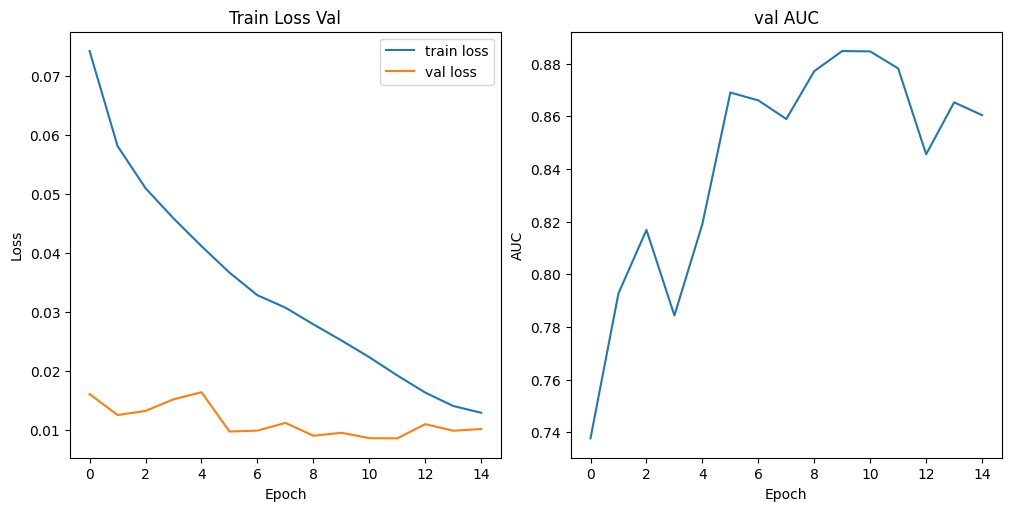

In [33]:
##### todo #####
# Plot training and validation curves
plot_results(train_losses, val_losses, val_aucs, metric_name="AUC")
# Compute testing auc score
# Choose to load model directly from the file.
model = torch.load(f"model_epoch{best_epoch}.pt", weights_only=False)
test_loss, test_auc = validate_epoch(model, device, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}\n"
      f"Testing auc score: {test_auc:.4f}")
################